<a href="https://colab.research.google.com/github/NH0917/ghg/blob/main/LAMA_sig_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install openfe
!pip install -U lightautoml
#!pip install optuna
#!pip install optuna-integration[lightgbm]
!pip install pygeohash

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.4/416.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 23.7 MB/s eta 0:00:00
   ━

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
#import optuna.integration.lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import io
import os
import math
import contextlib
#from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.preprocessing import LabelEncoder
import warnings
from tqdm import tqdm

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized

from logging import getLogger, INFO
import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor


warnings.simplefilter('ignore')

import sys

sys.path.append("/content/drive/MyDrive/signate/ghg/src/")
pd.set_option("display.max_columns",100)

#import my code
#import sub
#import plot_importance
#import train_evall_lgb

In [ ]:
class cfg:
    """Configuration class that holds hyperparameters for quicker experimenting"""
    num_folds = 30
    random_seed = 1
    n_jobs = 16
    n_features = 10

In [ ]:
train_path = "/content/drive/MyDrive/signate/ghg/exp_new/exp3/train_df.csv"
test_path = "/content/drive/MyDrive/signate/ghg/exp_new/exp3/test_df.csv"
sub_path = "/content/drive/MyDrive/signate/ghg/data/sample_submission.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sub_df = pd.read_csv(sub_path,header=None)

In [ ]:
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df['FacilityName'], test_df['FacilityName']
del train_df['LocationAddress'], test_df['LocationAddress']
del train_df['ZIP'], test_df['ZIP']
del train_df['IndustryType'], test_df['IndustryType']
del train_df['SecondPrimaryNAICS'], test_df['SecondPrimaryNAICS']

In [ ]:

two_digit_map     = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [ ]:
train_df['first_two_digit_primary_naics'] = train_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)
test_df['first_two_digit_primary_naics']  = test_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)

train_df['Economic_Sector']               = train_df['first_two_digit_primary_naics'].map(two_digit_map)
test_df['Economic_Sector']                = test_df['first_two_digit_primary_naics'].map(two_digit_map)

del train_df['first_two_digit_primary_naics'], test_df['first_two_digit_primary_naics']

econ_sector_train                         = train_df['Economic_Sector'].values
econ_sector_test                          = test_df['Economic_Sector'].values

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of Earth in kilometers (mean radius)
    R = 6371.0

    # Calculate the distance
    distance = R * c
    return distance

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat2, lon2)

def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
    # Extract the required columns once to NumPy arrays
    latitudes = train_df['Latitude'].values
    longitudes = train_df['Longitude'].values
    ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
    econ_sectors = train_df['Economic_Sector'].values

    # Filter NaN emissions directly
    valid_indices = ~np.isnan(ghg_emissions)

    latitudes = latitudes[valid_indices]
    longitudes = longitudes[valid_indices]
    ghg_emissions = ghg_emissions[valid_indices]
    econ_sectors = econ_sectors[valid_indices]

    # Parallelize distance calculation using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        distances = list(executor.map(calculate_distance,
                                     [lat1]*len(latitudes),
                                     [lon1]*len(longitudes),
                                     latitudes,
                                     longitudes))

    # Combine the results into a DataFrame
    near_df = pd.DataFrame({
        'Distance': distances,
        'GHG_emission_14': ghg_emissions,
        'Economic_Sector': econ_sectors
    })


    if train_point:
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()
        near_df = near_df.iloc[1:].reset_index(drop=True)
    else:
        # Sort distances by 'Distance'
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()

    # Filter by economic sector
    nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

    # Get the top N nearest for both economic sector and overall
    sub_near_econ = nearest_locations_econ_sector.head(neighbours)
    sub_nearest_locations = near_df.head(neighbours)

    # Compute weighted averages
    econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
    near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

    # Compute regular averages
    econ_average = sub_near_econ['GHG_emission_14'].mean()
    near_average = sub_nearest_locations['GHG_emission_14'].mean()

    return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [ ]:
neighbours = 10

file_path = f"test_distance_{neighbours}nbrs.csv"
if os.path.exists(file_path):
    print(f"{file_path} exists. ")
    test_distance = pd.read_csv(f"test_distance_{neighbours}nbrs.csv")
else:
    output = []
    for index in tqdm(range(test_df.shape[0])):

        lat1 = test_df.iloc[index]['Latitude']
        lon1 = test_df.iloc[index]['Longitude']
        econ_sector_ref = test_df.iloc[index]['Economic_Sector']
        x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours,train_point=False)
        output.append(x)

    test_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])

    test_distance.to_csv(f'test_distance_{neighbours}nbrs.csv',index=False)


file_path = f"train_distance_{neighbours}nbrs.csv"
if os.path.exists(file_path):
    print(f"{file_path} exists. ")
    train_distance = pd.read_csv(f'train_distance_{neighbours}nbrs.csv')
else:
    output = []
    for index in tqdm(range(train_df.shape[0])):
        lat1 = train_df.iloc[index]['Latitude']
        lon1 = train_df.iloc[index]['Longitude']
        econ_sector_ref = train_df.iloc[index]['Economic_Sector']
        x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours, train_point=True)
        output.append(x)

    train_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
    train_distance.to_csv('train_distance_{neighbours}nbrs.csv',index=False)



train_df = pd.concat((train_df,train_distance),axis=1)
test_df  = pd.concat((test_df,test_distance),axis=1)

100%|██████████| 4655/4655 [20:32<00:00,  3.78it/s]


In [ ]:
def create_features1(df):


    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

   # Year-over-year growth rate with NaN protection
    df['TRI_Air_Emissions_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                 'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

In [ ]:
def create_features2(df):


    # Year-over-year difference
    df['GHG_Direct_Emissions_YoY_Change_11'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']

    # Year-over-year growth rate for GHG Direct Emissions with NaN protection
    df['GHG_Direct_Emissions_Growth_Rate_11'] = np.where(
        df['GHG_Direct_Emissions_10_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_10_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_12'] = np.where(
        df['GHG_Direct_Emissions_11_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_11_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_13'] = np.where(
        df['GHG_Direct_Emissions_12_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_12_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']) / df['GHG_Direct_Emissions_12_in_metric_tons'],
        np.nan
    )

    return df


new_features2 = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                 'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                 ]
train_df      = create_features2(train_df)
test_df       = create_features2(test_df)

In [ ]:
def create_features3(df):
    df['TRI_to_GHG_Ratio_10'] = np.where(df['GHG_Direct_Emissions_10_in_metric_tons'].notna(),
                                     df['TRI_Air_Emissions_10_in_lbs'] / df['GHG_Direct_Emissions_10_in_metric_tons'],
                                     np.nan)

    df['TRI_to_GHG_Ratio_11'] = np.where(df['GHG_Direct_Emissions_11_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_11_in_lbs'] / df['GHG_Direct_Emissions_11_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_12'] = np.where(df['GHG_Direct_Emissions_12_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_12_in_lbs'] / df['GHG_Direct_Emissions_12_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_13'] = np.where(df['GHG_Direct_Emissions_13_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_13_in_lbs'] / df['GHG_Direct_Emissions_13_in_metric_tons'],
                                        np.nan)
    return df



train_df      = create_features3(train_df)
test_df       = create_features3(test_df)
new_features3 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

In [ ]:
#summary_df = train_df.groupby(['Economic_Sector', 'State']).agg({'GHG_Direct_Emissions_14_in_metric_tons': ['mean', 'median', 'max', 'min','count']})

#summary_df.columns = [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]

#summary_df = summary_df.reset_index()

#train_df = train_df.merge(summary_df, on=['Economic_Sector', 'State'], how='left')
#test_df  = test_df.merge(summary_df,  on=['Economic_Sector', 'State'], how='left')

In [ ]:
merged_df = pd.concat((train_df,test_df),axis=0)
for cols in ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']:
    le              = LabelEncoder()
    merged_df[cols] = le.fit_transform(merged_df[cols].values.reshape(-1,1))

train_df = merged_df.iloc[:train_df.shape[0],:]
test_df  = merged_df.iloc[train_df.shape[0]:,:]
train_df.shape,test_df.shape

((4655, 42), (2508, 42))

In [ ]:
target_col = "GHG_Direct_Emissions_14_in_metric_tons"

In [ ]:
dorp_col = ['GHG_Direct_Emissions_14_in_metric_tons_mean',
       'GHG_Direct_Emissions_14_in_metric_tons_median',
       'GHG_Direct_Emissions_14_in_metric_tons_max',
       'GHG_Direct_Emissions_14_in_metric_tons_min',
       'GHG_Direct_Emissions_14_in_metric_tons_count']

train_df.drop(columns=dorp_col,inplace=True)
test_df.drop(columns=dorp_col,inplace=True)

In [ ]:
task = Task('reg',loss="rmsle",metric="rmsle",greater_is_better=False)
roles = {
    "target":target_col
}

In [ ]:
from sklearn.model_selection import KFold

models = []

oof_pred = pd.DataFrame()

N_FOLDS = 5
TIMEOUT = 300
N_THREADS = 8

oof_dfs = pd.DataFrame()

kf = KFold(n_splits=cfg.num_folds,shuffle=True,random_state=42)


for i,(train_idx,val_idx) in enumerate(kf.split(train_df)):
  train_fold = train_df.iloc[train_idx].reset_index(drop=True)
  val_fold = train_df.iloc[val_idx].reset_index(drop=True)

  oof_df = pd.DataFrame()

  automl = TabularAutoML(task=task,
                          timeout=TIMEOUT,
                          cpu_limit=N_THREADS,
                          reader_params={"n_jobs":N_THREADS,"cv":N_THREADS,"random_state":123},
                           general_params = {"use_algos": [['rf','lgb','lgb_tuned','cb','cb_tuned','linear_l2']]}
                        )

  oof_pred = automl.fit_predict(train_fold, roles=roles, verbose=-1)
  oof_df["predict"] = automl.predict(val_fold).data[:,0]
  oof_df["target"] = val_fold[target_col]
  #print(rmsle(oof_df["target"],oof_df["predict"]))

  models.append(automl)

  oof_dfs = pd.concat([oof_dfs,oof_df]).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[312]	valid's l2: 0.572875
INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_2_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l2: 0.716038
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l2: 0.560993
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l2: 0.537159
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l2: 0.53414
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l2: 0.535414
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l2: 0.536763
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[420]	valid's l2: 0.533442
INFO2:lightautoml.ml_algo.base:===== Start working with fold 5 for Lvl_0_Pipe_2_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scor

In [ ]:
oof_dfs.reset_index(drop=True,inplace=True)

In [ ]:
def get_rmsle(y_true: np.array, y_pred: np.array) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric

    :param y_true: The ground truth labels given in the dataset
    :param y_pred: Our predictions
    :return: The RMSLE score
    """

    return mean_squared_log_error(y_true, y_pred, squared=False)

In [ ]:
get_rmsle(oof_dfs["target"],oof_dfs["predict"])

0.7576627686330851

In [ ]:
fast_fi = automl.get_feature_scores("fast")

<Axes: xlabel='Feature'>

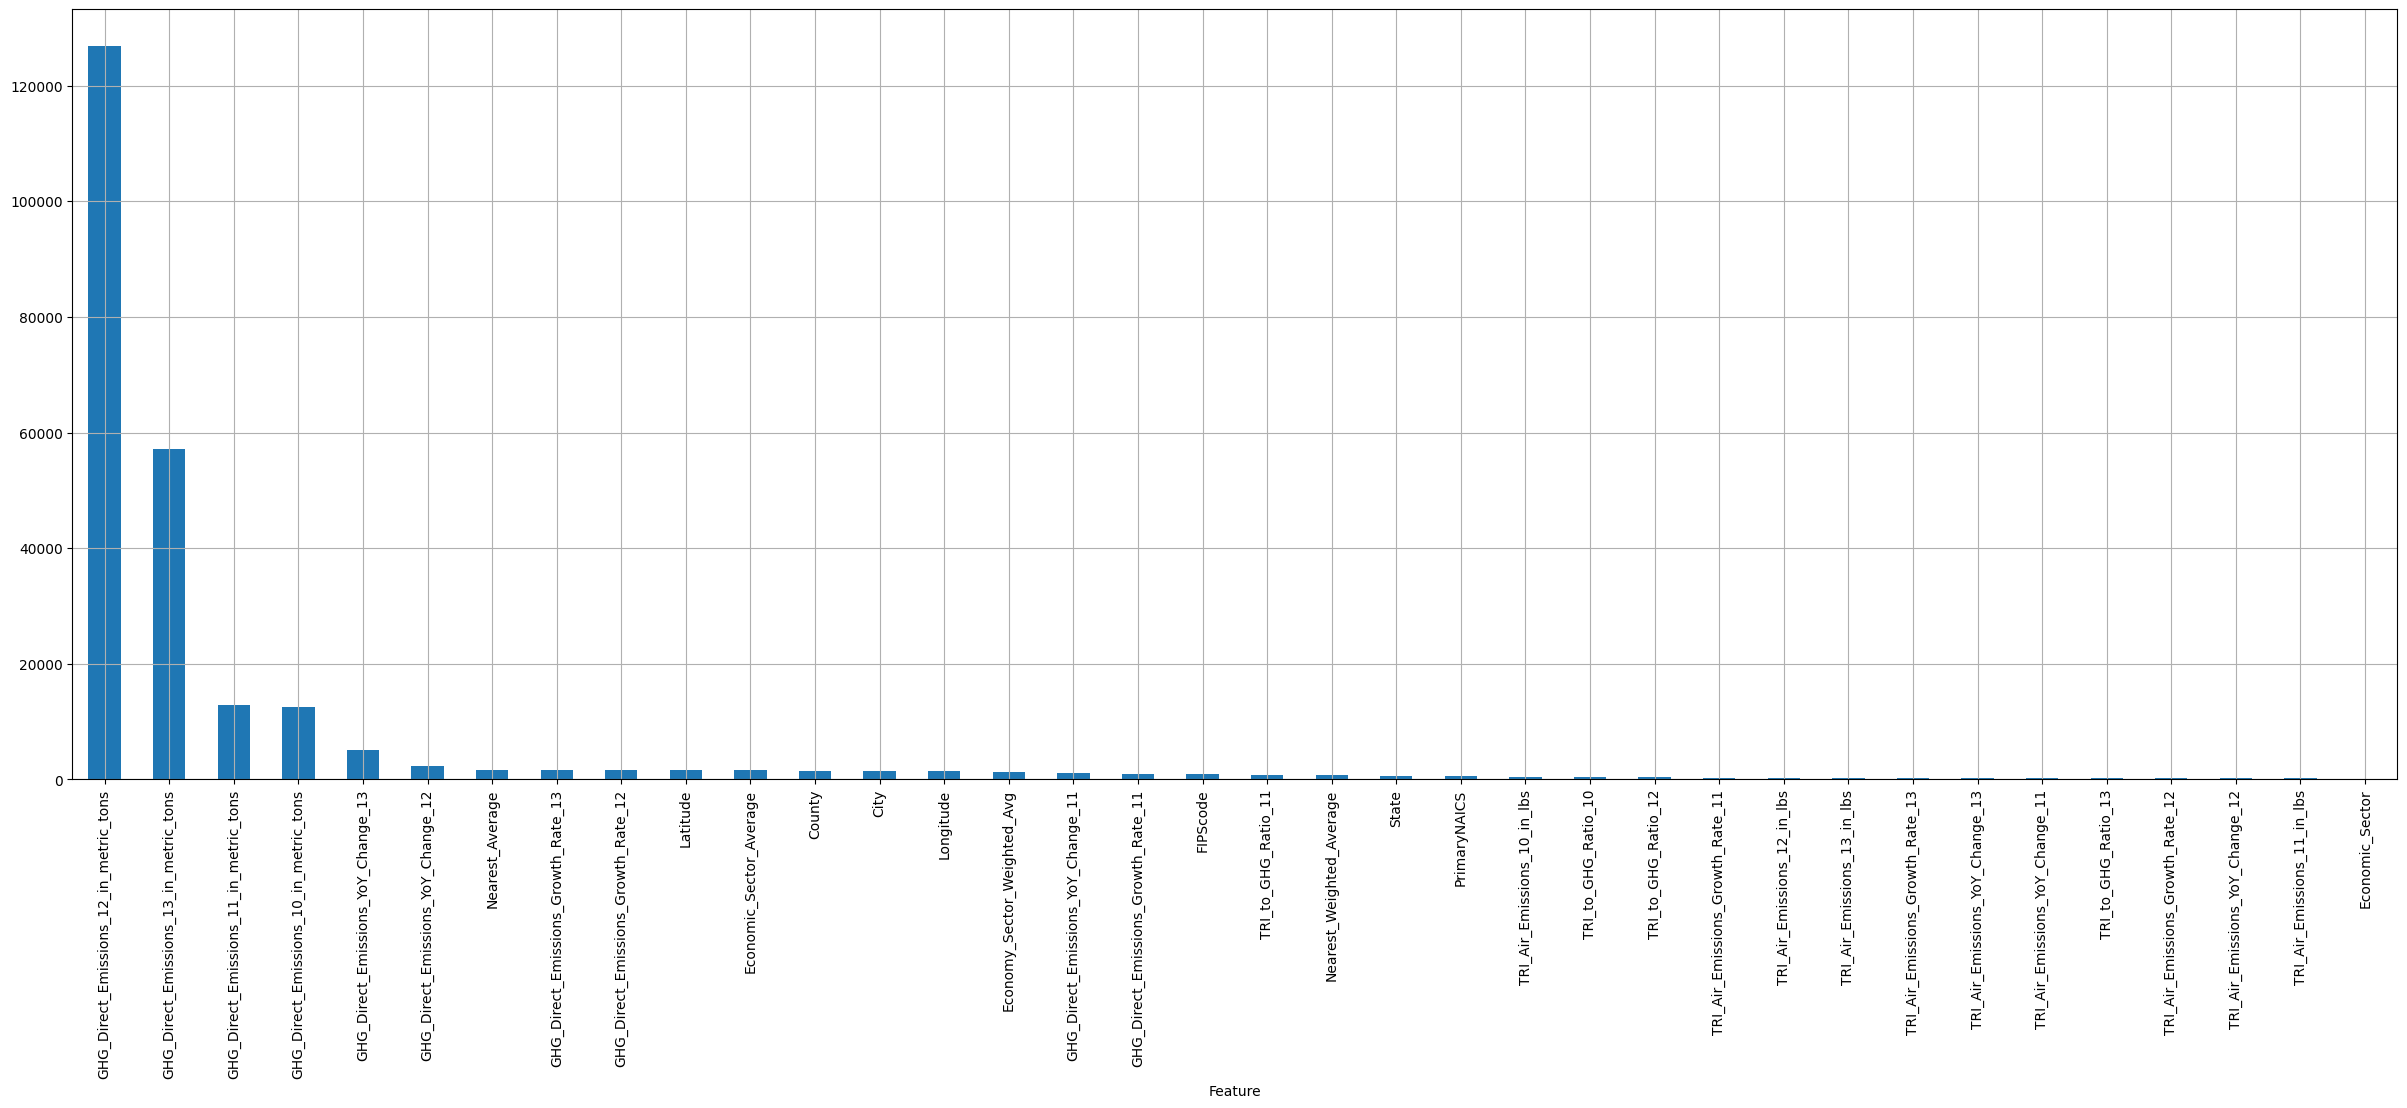

In [ ]:
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
output_path = "/content/drive/MyDrive/signate/ghg/exp_new/exp3"

train_df.to_csv(f"{output_path}/train_df.csv",index=False)
test_df.to_csv(f"{output_path}/test_df.csv",index=False)

In [ ]:
pred_df = pd.DataFrame()

fold = 1
for ml in models:
  pred_df[f"{fold}"] = ml.predict(test_df).data[:,0]
  fold += 1

In [ ]:
sub_df[1] = pred_df.mean(axis=1)

In [ ]:
output_path = "/content/drive/MyDrive/signate/ghg/exp_new/exp3"

sub_df.to_csv(f"{output_path}/sub_lama_sig_v6.csv",index=False,header=None)

In [ ]:
oof_dfs.to_csv(f"{output_path}/oof_lama_sig_v6.csv",index=False)